In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp=IterativeImputer(max_iter=10,random_state=0)
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
!pip install category_encoders
import category_encoders as ce
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV




In [ ]:
players=pd.read_csv('/content/drive/MyDrive/players_22.csv')
#players

<ipython-input-25-d203370647f8>:1: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  players=pd.read_csv('/content/drive/MyDrive/players_22.csv')


In [ ]:
male=pd.read_csv('/content/drive/MyDrive/male_players (legacy).csv')
#male

<ipython-input-26-35d6674b775b>:1: DtypeWarning: Columns (108) have mixed types. Specify dtype option on import or set low_memory=False.
  male=pd.read_csv('/content/drive/MyDrive/male_players (legacy).csv')


In [ ]:
male.drop(['player_url','league_id','league_level','league_name','club_team_id','club_name','club_position','club_jersey_number','club_loaned_from','release_clause_eur','player_tags','real_face','player_face_url','fifa_version','fifa_update','fifa_update_date','short_name','club_joined_date','nationality_id','nationality_name','nation_team_id','nation_position','nation_jersey_number','mentality_composure','goalkeeping_speed','player_id','ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm',	'rcm','rm','lwb','ldm',	'cdm','rdm','rwb','lb','lcb','cb','rcb','rb','gk'
], axis=1,inplace=True)
#male

In [ ]:

import pandas as pd
import numpy as np
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import xgboost as xgb

def preprocess_data(data, target_column='overall', top_n_features=10, missing_threshold=0.3):
    """
    Preprocess the data, train a Random Forest model to get feature importances, and select top features.
    """
    # Filter columns based on missing values threshold
    l = [i for i in data.columns if data[i].isnull().sum() < (missing_threshold * data.shape[0])]
    data = data[l]

    # Define the target column and separate features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Separate data types
    numeric_data = X.select_dtypes(include=np.number)

    # Impute missing values
    imp = IterativeImputer(max_iter=10, random_state=0)
    X_imputed = pd.DataFrame(np.round(imp.fit_transform(numeric_data)), columns=numeric_data.columns)

    # Initialize and train the Random Forest model on the entire feature set
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_imputed, y)

    # Get feature importances
    feature_importances = rf_model.feature_importances_

    # Create a DataFrame for visualization
    feature_importance_df = pd.DataFrame({
        'Feature': X_imputed.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df['Feature'][:top_n_features], feature_importance_df['Importance'][:top_n_features])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top Feature Importances from Random Forest')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # Select top features
    top_features = feature_importance_df['Feature'].head(top_n_features).tolist()

    # Return imputed features, top features, target, and imputer
    return X_imputed[top_features], y, top_features, imp





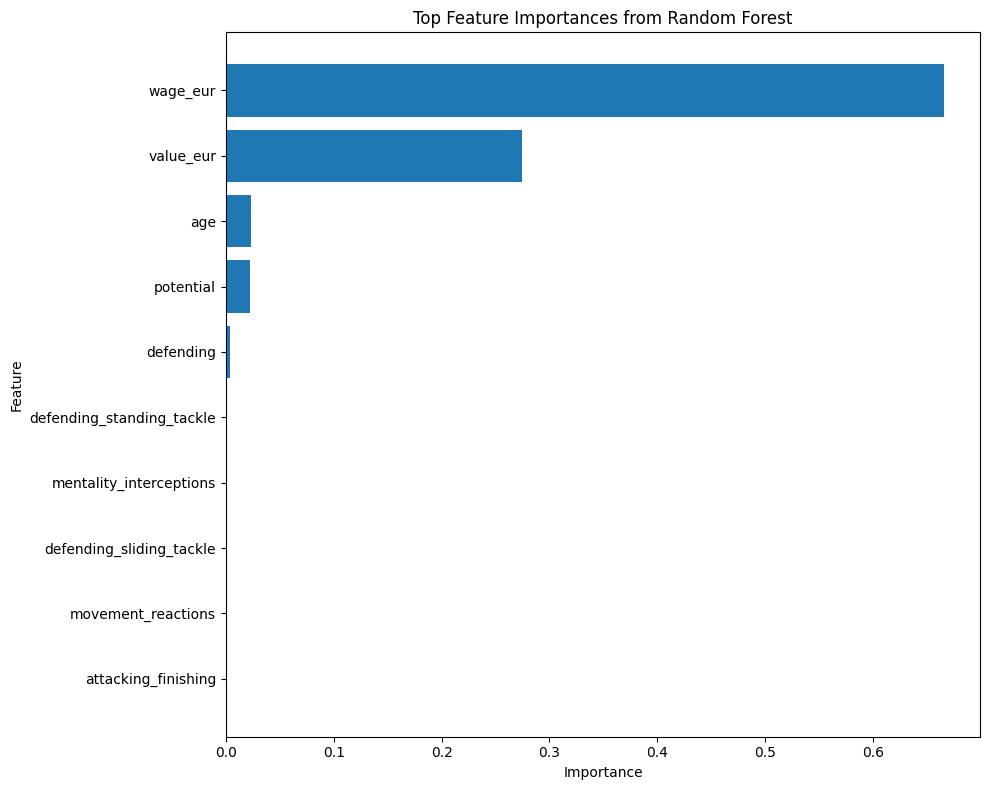

In [ ]:
# Split the data into training and test sets
train_data, test_data = train_test_split(male, test_size=0.2, random_state=42)

# Preprocess the training data
X_train, y_train, top_features, imputer = preprocess_data(train_data, target_column='overall')

# Preprocess the test data using the same imputer and features
X_test = test_data.drop(columns=['overall'])
X_test_numeric = X_test.select_dtypes(include=np.number)
X_test_imputed = pd.DataFrame(np.round(imputer.transform(X_test_numeric)), columns=X_test_numeric.columns)
X_test_selected = X_test_imputed[top_features]
y_test = test_data['overall']

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4]
}

In [ ]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error',
                           verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best MSE Score:", -grid_search.best_score_)

# Train the final model with the best parameters
best_rf_model = RandomForestRegressor(**grid_search.best_params_, random_state=42)
best_rf_model.fit(X_train, y_train)

# Make predictions on the test set
rf_predictions = best_rf_model.predict(X_test_selected)
mse_rf = mean_squared_error(y_test, rf_predictions)
r2_rf = r2_score(y_test, rf_predictions)
print(f"Random Forest Model - Mean Squared Error: {mse_rf:.2f}")
print(f"Random Forest Model - R-squared Score: {r2_rf:.2f}")




Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': 20, 'n_estimators': 300}
Best MSE Score: 0.27815735337709824
Random Forest Model - Mean Squared Error: 0.25
Random Forest Model - R-squared Score: 0.99


In [ ]:
# XGBoost Model
print("\nXGBoost Model:")
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test_selected)
mse_xgb = mean_squared_error(y_test, xgb_predictions)
r2_xgb = r2_score(y_test, xgb_predictions)
print(f"XGBoost Model - Mean Squared Error: {mse_xgb:.2f}")
print(f"XGBoost Model - R-squared Score: {r2_xgb:.2f}")



XGBoost Model:
XGBoost Model - Mean Squared Error: 0.43
XGBoost Model - R-squared Score: 0.99


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Grid search for XGBoost parameters
param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

# Perform GridSearchCV on the training data
grid_search = GridSearchCV(estimator=xgb.XGBRegressor(random_state=42),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           verbose=1)
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best MSE Score:", -grid_search.best_score_)

# Initialize the XGBoost regressor with the best parameters
optimized_xgb_model = xgb.XGBRegressor(
    learning_rate=grid_search.best_params_['learning_rate'],
    max_depth=grid_search.best_params_['max_depth'],
    n_estimators=grid_search.best_params_['n_estimators'],
    random_state=42
)

# Perform cross-validation on the training data
cv_scores = cross_val_score(optimized_xgb_model, X_train, y_train,
                            cv=5, scoring='neg_mean_squared_error')

# Convert MSE to positive values
mse_scores = -cv_scores
print("Cross-validation MSE scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("Standard deviation of MSE:", mse_scores.std())

# Fit the optimized model to the entire training data
optimized_xgb_model.fit(X_train, y_train)

# Make predictions on the test data
test_predictions = optimized_xgb_model.predict(X_test_selected)

# Calculate the mean squared error on test data
test_mse = mean_squared_error(y_test, test_predictions)
print("Optimized Mean Squared Error on test data:", test_mse)

# Calculate the R-squared score on test data
test_r2 = r2_score(y_test, test_predictions)
print("Optimized R-squared Score on test data:", test_r2)



Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best MSE Score: 0.2559601095653511
Cross-validation MSE scores: [0.22996251 0.28057432 0.2901047  0.24055395 0.23860507]
Mean MSE: 0.2559601095653511
Standard deviation of MSE: 0.02443822568953805
Optimized Mean Squared Error on test data: 0.23472488960980875
Optimized R-squared Score on test data: 0.9919276021986763


In [ ]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming train_data is your DataFrame and y_train is your target variable

# Preprocessing steps
categorical_cols = ['long_name', 'player_positions', 'preferred_foot', 'work_rate', 'body_type']
le = LabelEncoder()
for col in categorical_cols:
    train_data[col] = le.fit_transform(train_data[col].astype(str))

# Convert 'dob' to age if the column exists
if 'dob' in train_data.columns:
    train_data['age'] = pd.to_datetime('today').year - pd.to_datetime(train_data['dob']).dt.year
    train_data = train_data.drop('dob', axis=1)
else:
    print("Warning: 'dob' column not found. Skipping age calculation.")

# Process 'player_traits' if the column exists
if 'player_traits' in train_data.columns:
    train_data['trait_count'] = train_data['player_traits'].str.count(',') + 1
    train_data = train_data.drop('player_traits', axis=1)
else:
    print("Warning: 'player_traits' column not found. Skipping trait count calculation.")

# Ensure X and y have the same number of samples
common_index = train_data.index.intersection(y_train.index)
X = train_data.loc[common_index]
y = y_train.loc[common_index]

print(f"Number of samples in X: {len(X)}")
print(f"Number of samples in y: {len(y)}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initial LightGBM model
lgb_model = lgb.LGBMRegressor(random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    # 'num_leaves': [20, 30, 40],
    'max_depth': [-1, 10, 20],
    # 'reg_alpha': [0.0, 0.1, 0.5],
    # 'reg_lambda': [0.0, 0.1, 0.5]
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train, categorical_feature=categorical_cols)

# Print best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Lowest RMSE found:", np.sqrt(np.abs(grid_search.best_score_)))

# Train final model with best parameters
best_lgb_model = lgb.LGBMRegressor(**grid_search.best_params_, random_state=42)
best_lgb_model.fit(X_train, y_train, categorical_feature=categorical_cols)

# Predict on test data
lgb_predictions = best_lgb_model.predict(X_test)

# Evaluate the model
lgb_mse = mean_squared_error(y_test, lgb_predictions)
lgb_r2 = r2_score(y_test, lgb_predictions)
print("LightGBM Mean Squared Error:", lgb_mse)
print("LightGBM R-squared Score:", lgb_r2)

Number of samples in X: 9575
Number of samples in y: 9575
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3241
[LightGBM] [Info] Number of data points in the train set: 6128, number of used features: 56
[LightGBM] [Info] Start training from score 66.910738
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3244
[LightGBM] [Info] Number of data points in the train set: 6128, number of used features: 56
[LightGBM] [Info] Start training from score 66.888381
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3239


In [ ]:
# saving the model
import joblib
joblib.dump(optimized_xgb_model, 'xgb_model.joblib')

['xgb_model.joblib']

In [ ]:
from joblib import load

# Load the pretrained XGB model
loaded_model = load('xgb_model.joblib')

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


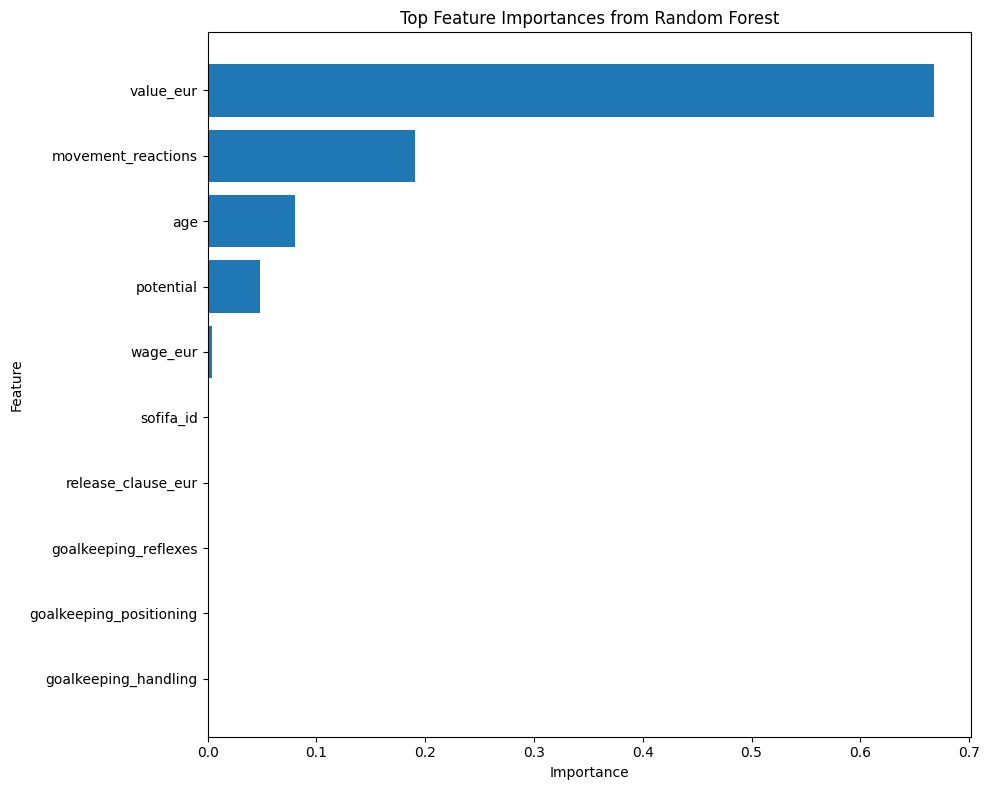

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- goalkeeping_speed
- nation_jersey_number
- nation_team_id


In [ ]:
# #Preprocessing training data
# train_data, test_data = train_test_split(players, test_size=0.2, random_state=42)
# X_train, y_train, top_features, imputer = preprocess_data(train_data, target_column='overall')
# X_test = test_data.drop(columns=['overall'])
# X_test_numeric = X_test.select_dtypes(include=np.number)
# X_test_imputed = pd.DataFrame(np.round(imputer.transform(X_test_numeric)), columns=X_test_numeric.columns)
# X_test_selected = X_test_imputed[top_features]
# y_test = test_data['overall']


In [1]:
# Preprocessing training data
players.drop(['player_url','league_level','league_name','club_team_id','club_name','club_position','club_jersey_number','club_loaned_from','release_clause_eur','player_tags','real_face','player_face_url','short_name','nationality_id','nationality_name','nation_team_id','nation_position','nation_jersey_number','mentality_composure','goalkeeping_speed','ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm',	'rcm','rm','lwb','ldm',	'cdm','rdm','rwb','lb','lcb','cb','rcb','rb','gk','player_face_url','club_logo_url','club_flag_url','nation_logo_url','nation_flag_url'
], axis=1,inplace=True)
train_data, test_data = train_test_split(players, test_size=0.2, random_state=42)
X_train, y_train, top_features, imputer = preprocess_data(train_data, target_column='overall')

# Preprocessing test data
X_test = test_data.drop(columns=['overall'])
X_test_numeric = X_test.select_dtypes(include=np.number)

# Ensure X_test_numeric has the same columns as what the imputer was fitted on
imputer_columns = imputer.feature_names_in_
X_test_numeric = X_test_numeric.reindex(columns=imputer_columns, fill_value=np.nan)

# Now transform
X_test_imputed = pd.DataFrame(np.round(imputer.transform(X_test_numeric)), columns=X_test_numeric.columns)

# Select top features
X_test_selected = X_test_imputed[top_features]
y_test = test_data['overall']

NameError: name 'train_test_split' is not defined

In [ ]:
optimized_xgb_model.fit(X_train, y_train)
predictions = optimized_xgb_model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:long_name: object, player_positions: object, dob: object, club_joined: object, preferred_foot: object, work_rate: object, body_type: object, player_traits: object, club_logo_url: object, club_flag_url: object, nation_logo_url: object, nation_flag_url: object